In [1]:
classes = ['sun', 'grapes', 'star']

In [2]:
classes

['sun', 'grapes', 'star']

# Imports

In [61]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf


# Load the Data

In [7]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None

    #randomize the dataset
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [8]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [9]:
print(len(x_train))

9600


In [10]:
x_train[0].shape

(784,)

In [11]:
x_test[0].shape

(784,)

In [63]:
class_names

['grapes', 'star', 'sun']

Show some random data

grapes


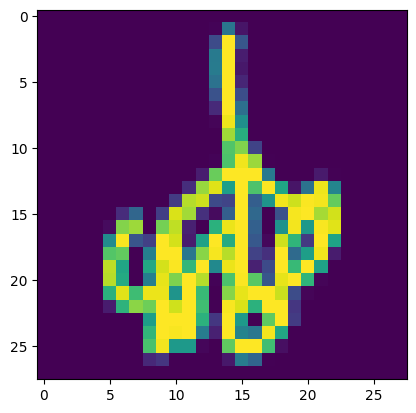

In [12]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28))
print(class_names[int(y_train[idx].item())])

# Preprocess the Data

In [13]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [14]:
x_train[0].shape

(28, 28, 1)

# The Model

In [43]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
#model.add(layers.Dense(100, activation='softmax'))

# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
#print(model.summary())

# Training

In [44]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
34/34 - 2s - loss: 0.7567 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.4563 - val_top_k_categorical_accuracy: 1.0000 - 2s/epoch - 53ms/step
Epoch 2/5
34/34 - 0s - loss: 0.3560 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3492 - val_top_k_categorical_accuracy: 1.0000 - 225ms/epoch - 7ms/step
Epoch 3/5
34/34 - 0s - loss: 0.2747 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2749 - val_top_k_categorical_accuracy: 1.0000 - 222ms/epoch - 7ms/step
Epoch 4/5
34/34 - 0s - loss: 0.2177 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2378 - val_top_k_categorical_accuracy: 1.0000 - 205ms/epoch - 6ms/step
Epoch 5/5
34/34 - 0s - loss: 0.1905 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2340 - val_top_k_categorical_accuracy: 1.0000 - 197ms/epoch - 6ms/step


# Testing

In [45]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 100.00%


# Inference

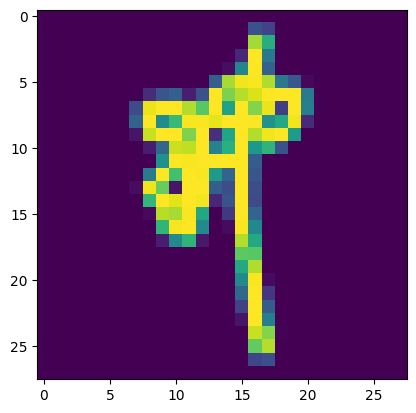

In [46]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())

In [47]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
p = model.predict(np.expand_dims(img, axis=0))
print(p)
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 [==============================] - 0s 17ms/step
[[0.20508929 0.7290648  0.06584592]]
['star', 'grapes', 'sun']


First element with highest probability is a predicted object.

# Save Model

In [56]:
model.save('model.h5')

In [58]:
from keras.models import load_model
trained_model = load_model('model.h5')

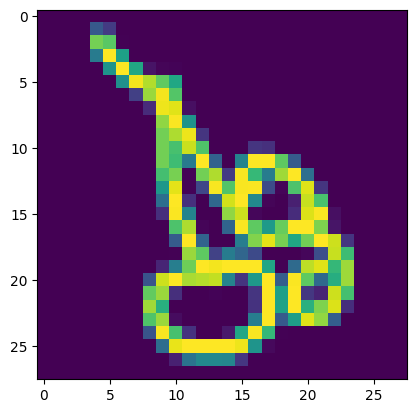

In [59]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze())

In [60]:
pred = model.predict(np.expand_dims(img, axis=0))[0]
print(p)
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

1/1 [==============================] - 0s 26ms/step
[[0.20508929 0.7290648  0.06584592]]
['grapes', 'star', 'sun']
